<a href="https://colab.research.google.com/github/Derwuel/Entrega_monopolio/blob/main/TP2/entrega_maquina2_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analisis de base de datos monopolio:

En la siguiente ejercicio se tratara de analizar algunos datos de una bases de datos especializada en monopolio, en concreto se tratará de analizar algunas características de los usuarios como: 'Id', 'Subsegmento', 'Sexo', 'Region', 'Edad', 'Renta', 'Antiguedad', 'Internauta', 'Adicional', 'Dualidad', 'Monoproducto', 'Ctacte',  'Consumo', 'Hipotecario', 'Debito', 'CambioPin', 'Cuentas', 'TC', con el fin de poder determinar cual es el tipo de persona que mas consume los productos del juego monopolio.

1.- Primera parte: esta parte del código nos permite obtener las librerías adecuadas para poder realizar el análisis de los datos.

In [ ]:
# Importar las librerías necesarias para el análisis y visualización de datos
%matplotlib inline
!pip install wquantiles
!pip install openpyxl
!pip install opendatasets


import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import opendatasets as od
import wquantiles
import os


from pathlib import Path
from scipy.stats import trim_mean
from statsmodels import robust
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

2.- Con esta parte del código se puede obtener la base de datos, a través de una API, esta base de datos está almacenada en la página kaggel y a través de un nombre de usuario y de una contraseña se puede acceder a los datos desde cualquier lugar.

Estos son los datos nesesarios para consumir la API y poder acceder a la base de datos

1.   "username":"derwuel"
2.   "key":"86b1d6a83dda1f96e18580fbd03a5544"


In [ ]:
# Descargar los datos desde Kaggle
dataset_link="https://www.kaggle.com/datasets/derwuel/trabajo-mono"
od.download(dataset_link)

# Cargar el archivo de Excel
os.chdir("trabajo-mono")
df = pd.read_excel("Base_clientes_Monopoly-0_prueba.xlsx")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: derwuel
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/derwuel/trabajo-mono


100%|██████████| 116M/116M [00:01<00:00, 75.7MB/s] 


3.- en esta parte del código comienza la limpieza de los datos, esto se hace con el fin de poder trabajar de manera más cómoda con ellos, en este caso procederemos a cambiar los datos del index, por los nombres de las columnas con el fin de identificarlos mejor y luego eliminaremos la primera fila de las columnas, ya que el index a tomado el valor de la primera fila, esta ya no es necesaria , luego tomaremos los datos de la columna ‘sexo’ y los remplasaremos para que sea mas facil de trabajar al momento de realizar el analicis.

In [ ]:
# Mostrar las primeras filas del DataFrame para entender los datos
print("Primeras filas del DataFrame:")
print(df.head())

# Revisar el tipo de datos de cada columna y cuántos valores nulos contiene
print("Tipos de datos y valores nulos:")
print(df.info())

#estos son los códigos que utilizaremos para hacer el primer sondeo de los datos
primeras_columnas = df.columns[:60]
valores_segunda_fila = df.iloc[0, :60]
print(f"Nombres de las columnas: {primeras_columnas}")
print(f"Valores de la segunda fila: {valores_segunda_fila}")


# Cambiar los nombres de las columnas por los valores de la fila 0
df.columns = df.iloc[0]


# Eliminar la fila 0 ya que ahora es innecesaria (contiene los nuevos nombres de columnas)
df = df.drop(df.index[0])


#este parte del codigo existe para poder trasformar los datos de tipo str a datos numericos
df['Sexo'] = df['Sexo'].replace({'H': 1, 'M': 2})

# Definir las columnas a verificar
columnas_a_verificar = ['Id', 'Subsegmento', 'Sexo', 'Region', 'Edad', 'Renta', 'Antiguedad', 'Internauta',
                        'Adicional', 'Dualidad', 'Monoproducto', 'Ctacte', 'Consumo', 'Hipotecario', 'Debito',
                        'CambioPin', 'Cuentas', 'TC']

# Mostrar estadísticas descriptivas básicas para entender los datos
print("Estadísticas descriptivas:")
print(df[columnas_a_verificar].describe())

# Identificación de valores nulos
print("Valores nulos por columna:")
print(df[columnas_a_verificar].isnull().sum())


Primeras filas del DataFrame:
    1          1.1   1.2     1.3   1.4     1.5         1.6         1.7  \
0  Id  Subsegmento  Sexo  Region  Edad   Renta  Antiguedad  Internauta   
1   1          160     M      13    43     NaN         130           1   
2   2          160     H      13    46  143640          69           1   
3   3          170     H      13    45  929106          24           1   
4   4          151     H      13    46  172447         134           0   

         1.8       1.9  ...        1.565        1.566        1.567  \
0  Adicional  Dualidad  ...  PagoNac_T01  PagoInt_T01  EeccNac_T01   
1          1         0  ...        33000            0      1099866   
2          0         0  ...       300000            0       214592   
3          1         0  ...       216676            0            0   
4          1         0  ...        60000            0       272762   

         1.568      1.569      1.570      1.571       1.572   1.573 574  
0  EeccInt_T01  UsoL1_T01  Uso

4.- una vez lista con la limpieza inicial trataremos de rellenar los datos faltantes, estos datos pueden producirse cuando la base de datos se corrompe o simplemente nunca existieron, primero tomaremos todos los datos que queremos imputar, y los transformaremos a un formato que permita su procesado, luego usaremos el método KNN(vecinos cercanos) para poder rellenar los datos faltantes y finalmente, devolveremos los datos a un formato fácil de entender para todos los procesos.

In [ ]:
# Convertir las columnas seleccionadas a formato float32 para la imputación
df[columnas_a_verificar] = df[columnas_a_verificar].astype('float32')

# Imputación de valores faltantes usando KNN
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df[columnas_a_verificar]), columns=columnas_a_verificar)

# Convertir los datos de nuevo a sus tipos originales
df_imputed[columnas_a_verificar] = df_imputed[columnas_a_verificar].astype('int64')

# Estandarización de los datos numéricos
scaler = StandardScaler()
df_imputed[columnas_a_verificar] = scaler.fit_transform(df_imputed[columnas_a_verificar])

print("Datos después de la imputación y estandarización:")
print(df_imputed.head())


Datos después de la imputación y estandarización:
         Id  Subsegmento      Sexo    Region      Edad     Renta  Antiguedad  \
0 -1.732017    -0.752290  1.075150  0.640485  0.323032  1.278702    2.553917   
1 -1.731949    -0.752290 -0.930102  0.640485  0.548555 -1.373639    0.843902   
2 -1.731881    -0.410717 -0.930102  0.640485  0.473381  0.519543   -0.417584   
3 -1.731814    -1.059706 -0.930102  0.640485  0.548555 -1.304206    2.666049   
4 -1.731746    -0.410717 -0.930102  0.640485  0.548555  0.221017    2.161455   

   Internauta  Adicional  Dualidad  Monoproducto    Ctacte  Consumo  \
0    0.679384   1.703963 -0.785122     -0.259607  0.284213 -0.03001   
1    0.679384  -0.586867 -0.785122     -0.259607  0.284213 -0.03001   
2    0.679384   1.703963 -0.785122     -0.259607  0.284213 -0.03001   
3   -1.471922   1.703963 -0.785122      3.851970 -3.518486 -0.03001   
4   -1.471922   1.703963  1.273688     -0.259607  0.284213 -0.03001   

   Hipotecario    Debito  CambioPin   Cuen

5.- aqui se esta realisando un modelo de regresión lineal para predecir el consumo de los los usuarios y de esa forma determinar, quienes son mas adecuados a la hora de enfocar la publisidad de la marca.

In [ ]:
# Definir la variable objetivo para la regresión (target) como 'Consumo'
X = df_imputed.drop(columns=['Consumo'])
y = df_imputed['Consumo']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear y entrenar un modelo de regresión lineal
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Hacer predicciones sobre el conjunto de prueba
y_pred = reg_model.predict(X_test)

# Evaluar el modelo
print("Evaluación del modelo de regresión:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


Evaluación del modelo de regresión:
MSE: 0.8694212633796877
R²: 0.00023087610770589073


Se usa un modelo de árbol de decisión para predecir el sexo, evaluando con la métrica de accuracy y de esa forma determinar, quienes son mas adecuados a la hora de enfocar la publisidad de la marca.

In [ ]:
# Definir la variable objetivo para clasificación como 'Sexo'
le = LabelEncoder()
df_imputed['Sexo'] = le.fit_transform(df_imputed['Sexo'])
X_class = df_imputed.drop(columns=['Sexo'])
y_class = df_imputed['Sexo']

# Dividir los datos en conjuntos de entrenamiento y prueba para clasificación
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.3, random_state=42)

# Crear y entrenar un modelo de árbol de decisión
clf_model = DecisionTreeClassifier(random_state=42)
clf_model.fit(X_train_class, y_train_class)

# Hacer predicciones sobre el conjunto de prueba
y_pred_class = clf_model.predict(X_test_class)

# Evaluar el modelo de clasificación
print("Evaluación del modelo de clasificación:")
print("Accuracy:", accuracy_score(y_test_class, y_pred_class))

# Realizar validación cruzada para asegurar la robustez del modelo
cross_val_scores = cross_val_score(clf_model, X_class, y_class, cv=5)
print("Validación cruzada (Accuracy):", np.mean(cross_val_scores))


Evaluación del modelo de clasificación:
Accuracy: 0.5199504498630851
Validación cruzada (Accuracy): 0.49202026584937497


5.-  esta parte del código son los datos expresados en formato de gráficos con el fin de poder analizar la informacion de manera mas clara y concisa.

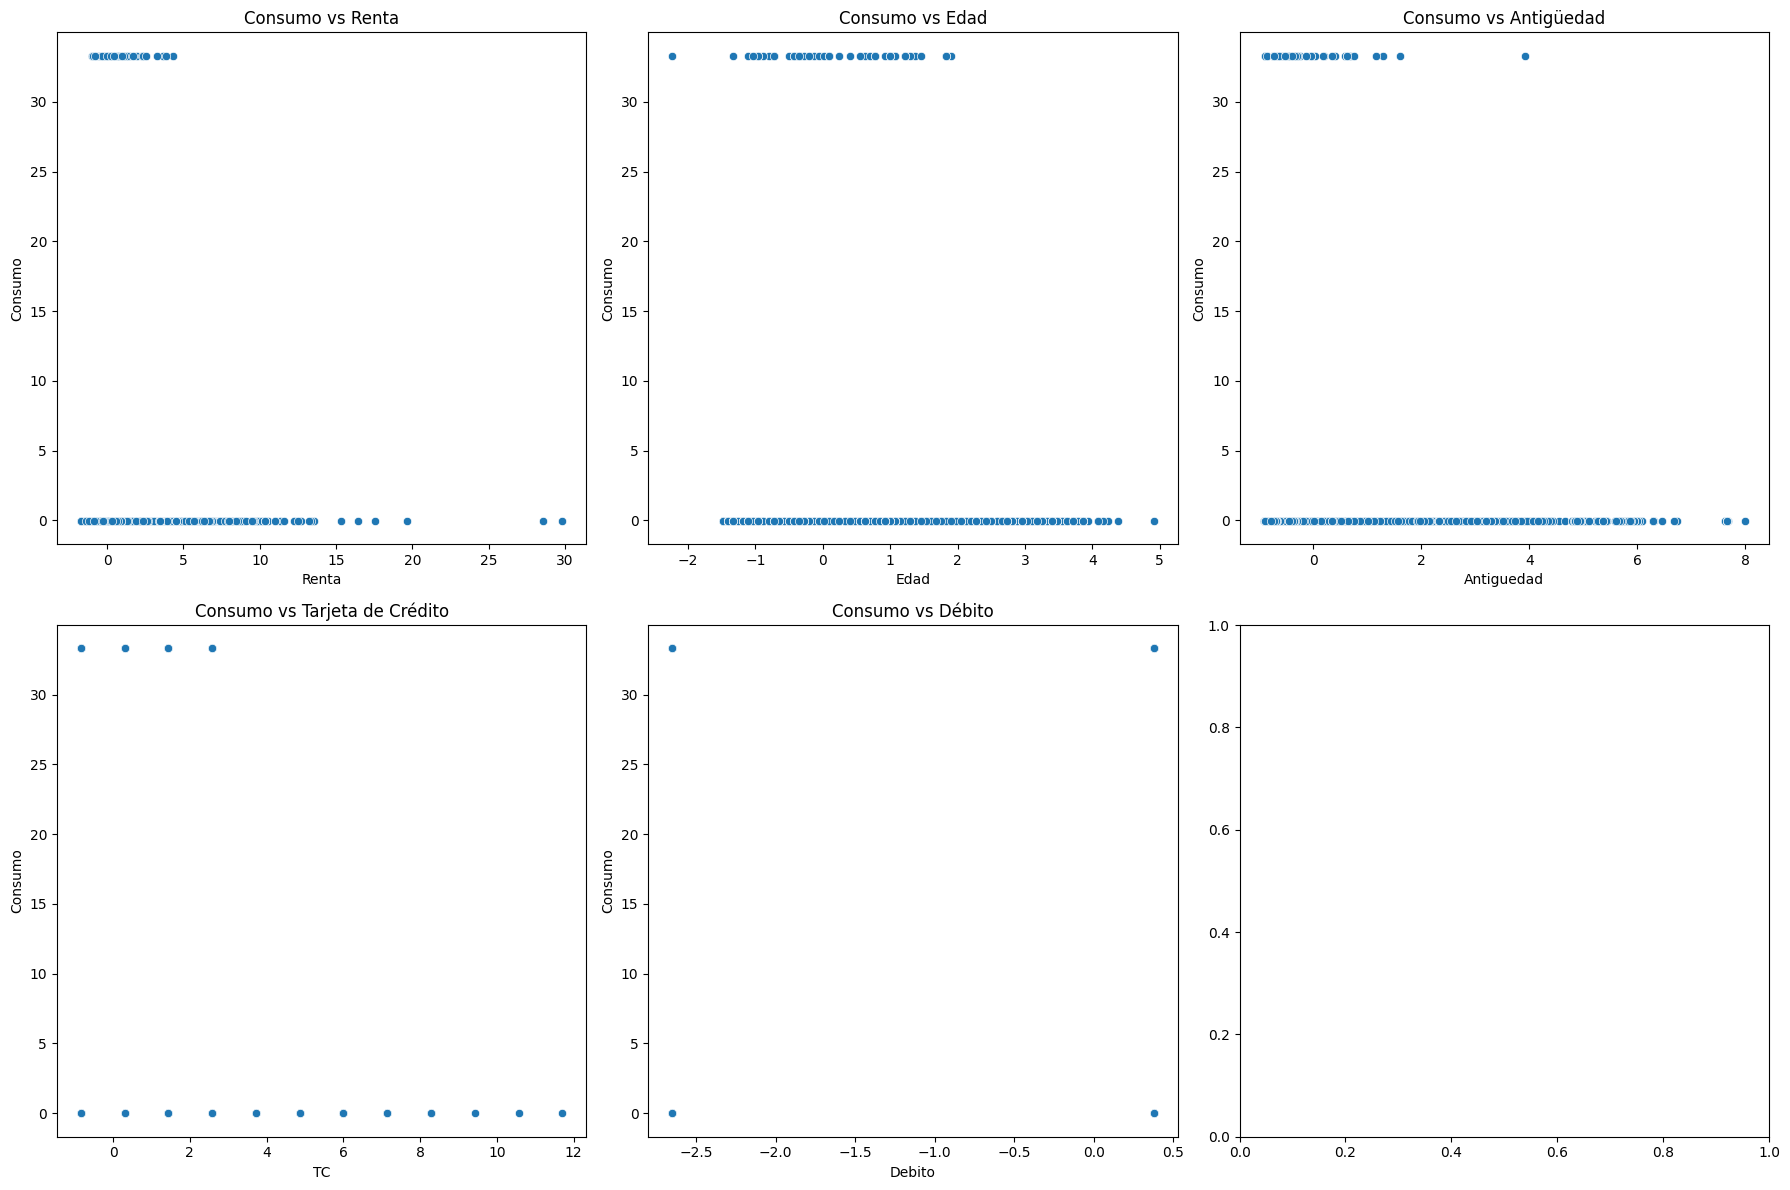

In [ ]:
# Crear gráficos de dispersión para analizar la relación entre Consumo y otras variables
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

sb.scatterplot(x='Renta', y='Consumo', data=df_imputed, ax=axes[0, 0])
sb.scatterplot(x='Edad', y='Consumo', data=df_imputed, ax=axes[0, 1])
sb.scatterplot(x='Antiguedad', y='Consumo', data=df_imputed, ax=axes[0, 2])
sb.scatterplot(x='TC', y='Consumo', data=df_imputed, ax=axes[1, 0])
sb.scatterplot(x='Debito', y='Consumo', data=df_imputed, ax=axes[1, 1])

axes[0, 0].set_title('Consumo vs Renta')
axes[0, 1].set_title('Consumo vs Edad')
axes[0, 2].set_title('Consumo vs Antigüedad')
axes[1, 0].set_title('Consumo vs Tarjeta de Crédito')
axes[1, 1].set_title('Consumo vs Débito')

plt.tight_layout()
plt.show()
